In [38]:
#0. CASO 8: CARGAR LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
import shap
from scipy.stats import chi2_contingency

In [2]:
#1. CARGAR DE DATOS
df = pd.read_csv("taller2_MLE.csv")

In [3]:
df.head()

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0


In [ ]:
# 2.ANALISIS EXPLORATORIO:ESTADISTICOS VARIABLES DISCRETAS Y/O CONTINUAS
# Comentario: Se observa que no hay presencia de Missing.
df.describe()

,edad,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,cerrara_cuenta
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,46.141000,20416.034312,2.987800,6.047000,0.699000,0.612400,0.489000,3.018240,34.986158,0.140400
std,16.357733,13588.538852,1.420583,2.484195,0.458739,0.487251,0.700555,1.145849,8.156743,0.347436
min,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000,0.000000
25%,32.000000,9780.610000,2.000000,4.000000,0.000000,0.000000,0.000000,2.000000,29.570000,0.000000
50%,46.000000,19784.830000,3.000000,6.000000,1.000000,1.000000,0.000000,3.000000,35.120000,0.000000
75%,60.000000,29887.305000,4.000000,8.000000,1.000000,1.000000,1.000000,4.000000,40.490000,0.000000
max,74.000000,66416.670000,5.000000,17.000000,1.000000,1.000000,6.000000,5.000000,65.040000,1.000000


In [ ]:
# 2.ANALISIS EXPLORATORIO:DISTRIBUCION DEL TARGET
df['cerrara_cuenta'].value_counts()
# Comentario: Se evidencia un desbalance de clase (1):14% y (0):86%. 

cerrara_cuenta
0    4298
1     702
Name: count, dtype: int64

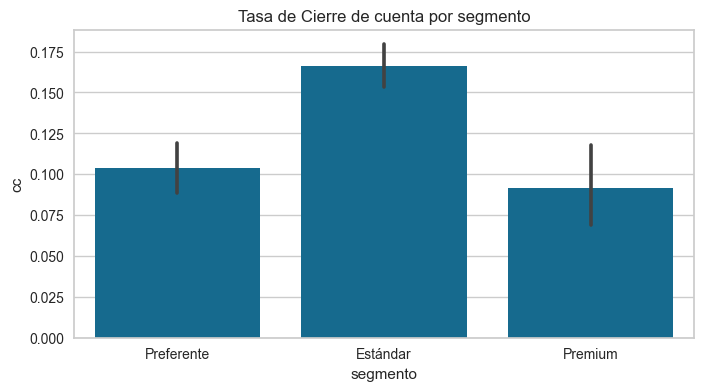

In [ ]:
#3.ANALISIS EXPLORATORIO:
df['cc']=df['cerrara_cuenta']
plt.figure(figsize=(8,4))
sns.barplot(data=df,x='segmento',y='cc')
plt.title("Tasa de Cierre de cuenta por segmento")
plt.show()

In [ ]:
#4.ANALISIS EXPLORATORIO:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   edad                   5000 non-null   int64  
 1   segmento               5000 non-null   object 
 2   saldo_total            5000 non-null   float64
 3   numero_productos       5000 non-null   int64  
 4   visitas_app_mes        5000 non-null   int64  
 5   usa_web                5000 non-null   int64  
 6   usa_tarjeta_credito    5000 non-null   int64  
 7   reclamos_6m            5000 non-null   int64  
 8   satisfaccion_encuesta  5000 non-null   float64
 9   tasa_credito_personal  5000 non-null   float64
 10  rango_ingresos         5000 non-null   object 
 11  region                 5000 non-null   object 
 12  cerrara_cuenta         5000 non-null   int64  
 13  cc                     5000 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 547.0+ 

In [48]:
# 5: EVALUAR BIVARIADO: 
# COMENTARIOS:Para evaluar la correlacion, algunas variables continuas se categorizan
# Por ejemplo: edad,saldo_total y visitas_app_mes

df['categoria_edad'] = pd.cut(df['edad'],
                         bins=[18, 29, 49, 59, 69 ,74],
                         labels=["18-29", "30-49", "50-59", "60-69","70-74"])

min_saldo_total = df['saldo_total'].min()
max_saldo_total = df['saldo_total'].max()
df['categoria_saldo_total'] = np.where(df['saldo_total']==0,'Sin saldo',
                                       pd.cut(df['saldo_total'],
                                          bins=[0, 9000, 19000, 29000,max_saldo_total],
                                          labels=["<=9000", "(9000-19000]", "(19000-29000]", ">29000"],
                                          include_lowest=False))


min_visitas_app_mes = df['visitas_app_mes'].min()
max_visitas_app_mes = df['visitas_app_mes'].max()
df['categoria_visitas_app'] = np.where(df['visitas_app_mes'] == 0, 
                                       'Sin visitas',  # Categoría especial para 0
                                       pd.cut(df['visitas_app_mes'],
                                              bins=[0, 4, 6, 8, max_visitas_app_mes],
                                              labels=["<=4", "(4-6]", "(6-8]", ">8"],
                                              include_lowest=False  # Importante para excluir 0
                                              ))

min_tasa = df['tasa_credito_personal'].min()
max_tasa = df['tasa_credito_personal'].max()
df['categoria_tasacredito'] = pd.cut(df['tasa_credito_personal'],
                                              bins=[0, 10, 29, 35,40, max_tasa],
                                              labels=["<=10", "10-29", "29-35", "35-40",">40"],
                                              include_lowest=False)

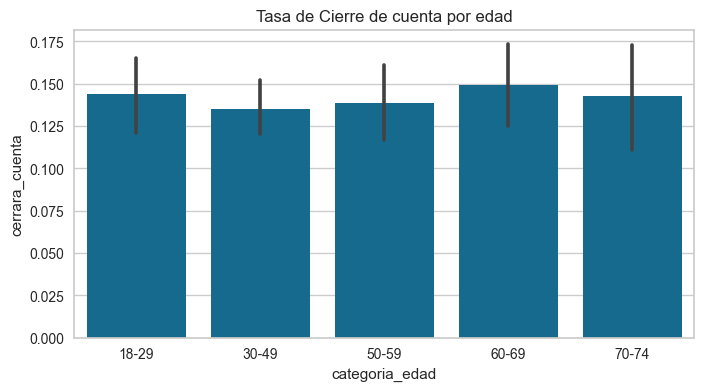

In [49]:
# 6.ANALISIS EXPLORATORIO:
plt.figure(figsize=(8,4))
sns.barplot(data=df,x='categoria_edad',y='cerrara_cuenta')
plt.title("Tasa de Cierre de cuenta por edad")
plt.show()

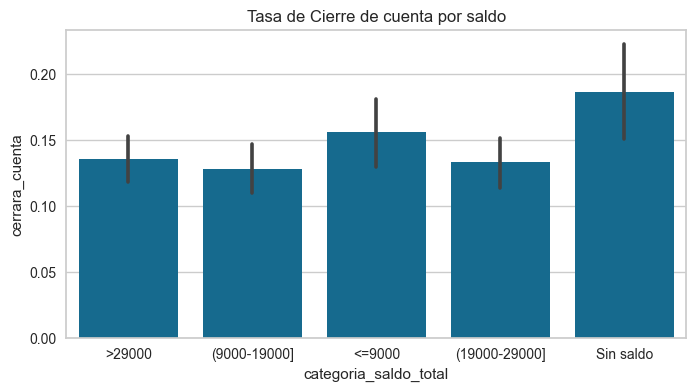

In [50]:
# 7. ANALISIS EXPLORATORIO:
plt.figure(figsize=(8,4))
sns.barplot(data=df,x='categoria_saldo_total',y='cerrara_cuenta')
plt.title("Tasa de Cierre de cuenta por saldo")
plt.show()

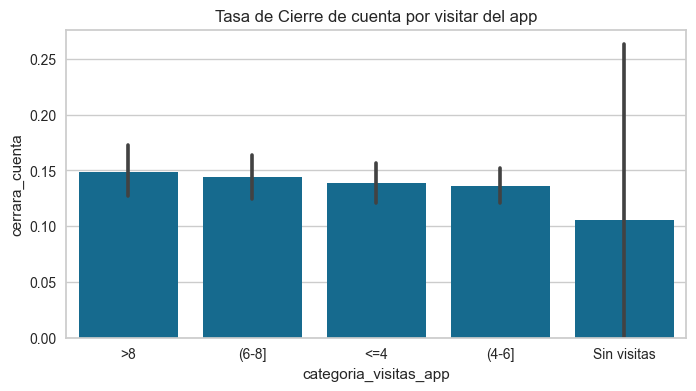

In [51]:
# 8. ANALISIS EXPLORATORIO:
plt.figure(figsize=(8,4))
sns.barplot(data=df,x='categoria_visitas_app',y='cerrara_cuenta')
plt.title("Tasa de Cierre de cuenta por visitar del app")
plt.show()

In [52]:
df['categoria_visitas_app'].value_counts()

categoria_visitas_app
(4-6]          1601
<=4            1388
(6-8]          1203
>8              789
Sin visitas      19
Name: count, dtype: int64

In [53]:
df['categoria_saldo_total'].value_counts()

categoria_saldo_total
>29000           1346
(19000-29000]    1257
(9000-19000]     1240
<=9000            712
Sin saldo         445
Name: count, dtype: int64

In [54]:
# 8. ANALISIS DE CORRELACION
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   edad                   5000 non-null   int64   
 1   segmento               5000 non-null   object  
 2   saldo_total            5000 non-null   float64 
 3   numero_productos       5000 non-null   int64   
 4   visitas_app_mes        5000 non-null   int64   
 5   usa_web                5000 non-null   int64   
 6   usa_tarjeta_credito    5000 non-null   int64   
 7   reclamos_6m            5000 non-null   int64   
 8   satisfaccion_encuesta  5000 non-null   float64 
 9   tasa_credito_personal  5000 non-null   float64 
 10  rango_ingresos         5000 non-null   object  
 11  region                 5000 non-null   object  
 12  cerrara_cuenta         5000 non-null   int64   
 13  cc                     5000 non-null   int64   
 14  categoria_edad         4914 non-null   c

In [55]:
# 8. ANALISIS DE CORRELACION
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.sum().sum()
    phi2 = chi2 / n
    r, k = ct.shape
    denom = min(r - 1, k - 1)
    if denom == 0:
        return np.nan
    return np.sqrt(phi2 / denom)

In [57]:
categorical_vars=[
    'segmento',
    'numero_productos',
    'usa_web',
    'usa_tarjeta_credito',
    'reclamos_6m',
    'satisfaccion_encuesta',
    'rango_ingresos',
    'region',
    'categoria_edad',
    'categoria_saldo_total',
    'categoria_visitas_app',
    'categoria_tasacredito'
]

for var in categorical_vars:
    v = cramers_v(df[var], df['cerrara_cuenta'])
    print(f"La correlación entre '{var}' y 'cerrara_cuenta' es: {v:.4f}")

# COMENTARIO: Según los resultados la variable con mayor correlación es satisfaccion_encuesta con el target. 

La correlación entre 'segmento' y 'cerrara_cuenta' es: 0.0929
La correlación entre 'numero_productos' y 'cerrara_cuenta' es: 0.0439
La correlación entre 'usa_web' y 'cerrara_cuenta' es: 0.0040
La correlación entre 'usa_tarjeta_credito' y 'cerrara_cuenta' es: 0.0220
La correlación entre 'reclamos_6m' y 'cerrara_cuenta' es: 0.0570
La correlación entre 'satisfaccion_encuesta' y 'cerrara_cuenta' es: 0.1780
La correlación entre 'rango_ingresos' y 'cerrara_cuenta' es: 0.0226
La correlación entre 'region' y 'cerrara_cuenta' es: 0.0084
La correlación entre 'categoria_edad' y 'cerrara_cuenta' es: 0.0147
La correlación entre 'categoria_saldo_total' y 'cerrara_cuenta' es: 0.0483
La correlación entre 'categoria_visitas_app' y 'cerrara_cuenta' es: 0.0142
La correlación entre 'categoria_tasacredito' y 'cerrara_cuenta' es: 0.0236


In [126]:
# 9.PYCARET: SETUP CON TÉNICAS AVANZADAS

clf = setup(
    data=df,
    target='cerrara_cuenta',
    session_id=2025,
    categorical_features=['segmento', 'usa_web', 'usa_tarjeta_credito', 'satisfaccion_encuesta','rango_ingresos','region'],
    ignore_features=['categoria_edad','categoria_saldo_total','categoria_visitas_app','categoria_tasacredito','cc'],
    normalize=True,
    fold=5,
    #feature_selection=False,
    remove_multicollinearity=False,
    transformation=True,
    transformation_method='yeo-johnson',
    verbose=False
)

In [128]:
# Comparar modelos automáticamente
best_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:57:08
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8597,0.6161,0.0000,0.0000,0.0000,0.0000,0.0000,3.7020
svm,SVM - Linear Kernel,0.8597,0.5610,0.0000,0.0000,0.0000,0.0000,0.0000,0.0880
ridge,Ridge Classifier,0.8597,0.6157,0.0000,0.0000,0.0000,0.0000,0.0000,0.0800
lda,Linear Discriminant Analysis,0.8597,0.6157,0.0000,0.0000,0.0000,0.0000,0.0000,0.0860
dummy,Dummy Classifier,0.8597,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0840
rf,Random Forest Classifier,0.8583,0.6073,0.0000,0.0000,0.0000,-0.0028,-0.0117,0.2840
et,Extra Trees Classifier,0.8560,0.6075,0.0204,0.2832,0.0379,0.0207,0.0427,0.2480
ada,Ada Boost Classifier,0.8557,0.6052,0.0020,0.1000,0.0040,-0.0048,-0.0107,0.1500
gbc,Gradient Boosting Classifier,0.8554,0.6030,0.0102,0.2038,0.0193,0.0059,0.0150,0.2680
lightgbm,Light Gradient Boosting Machine,0.8506,0.5797,0.0387,0.2603,0.0664,0.0332,0.0507,0.3320


In [130]:
# 9.PYCARET: SETUP CON TÉNICAS AVANZADAS

clf_balanceo = setup(
    data=df,
    target='cerrara_cuenta',
    session_id=2025,
    categorical_features=['segmento', 'usa_web', 'usa_tarjeta_credito', 'satisfaccion_encuesta','rango_ingresos','region'],
    ignore_features=['categoria_edad','categoria_saldo_total','categoria_visitas_app','categoria_tasacredito','cc'],
    normalize=True,
    #feature_selection=False,
    remove_multicollinearity=False,
    transformation=True,
    transformation_method='yeo-johnson',
    fix_imbalance=True,
    fold=5,
    verbose=False
)

In [131]:
# Comparar modelos automáticamente
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8597,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1420
qda,Quadratic Discriminant Analysis,0.8594,0.5467,0.0000,0.0000,0.0000,-0.0006,-0.0031,0.0740
gbc,Gradient Boosting Classifier,0.8566,0.6106,0.0041,0.0900,0.0078,-0.0005,-0.0050,0.6460
svm,SVM - Linear Kernel,0.8557,0.5672,0.0143,0.2000,0.0266,0.0119,0.0252,0.0820
rf,Random Forest Classifier,0.8557,0.6172,0.0163,0.2700,0.0304,0.0146,0.0333,0.2400
ada,Ada Boost Classifier,0.8546,0.6050,0.0163,0.2229,0.0303,0.0124,0.0253,0.1700
et,Extra Trees Classifier,0.8534,0.6068,0.0347,0.2949,0.0616,0.0341,0.0579,0.2040
lr,Logistic Regression,0.8511,0.6186,0.0408,0.2632,0.0696,0.0367,0.0546,0.0820
lightgbm,Light Gradient Boosting Machine,0.8463,0.5962,0.0244,0.1753,0.0427,0.0076,0.0131,0.3980
lda,Linear Discriminant Analysis,0.8431,0.6138,0.0672,0.2703,0.1065,0.0536,0.0700,0.0800


In [132]:
nb=create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7029,0.6151,0.4490,0.2222,0.2973,0.1354,0.1488
1,0.6957,0.5802,0.3571,0.1892,0.2473,0.0787,0.0850
2,0.7114,0.6426,0.4796,0.2374,0.3176,0.1603,0.1762
3,0.6371,0.5343,0.3265,0.1455,0.2013,0.0094,0.0106
4,0.6971,0.5825,0.4040,0.2073,0.2740,0.1070,0.1165
Mean,0.6889,0.5909,0.4033,0.2003,0.2675,0.0981,0.1074
Std,0.0264,0.0364,0.0564,0.0317,0.0406,0.0521,0.0573


In [133]:
#10. Tune_model(): Ajuste automático de hiperparámetros
final = tune_model(best_model,optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4757,0.4859,0.5000,0.1335,0.2108,-0.0131,-0.0196
1,0.5014,0.5393,0.5918,0.1580,0.2495,0.0366,0.0546
2,0.4786,0.4918,0.5102,0.1362,0.2151,-0.0076,-0.0114
3,0.5014,0.5393,0.5918,0.1580,0.2495,0.0366,0.0546
4,0.4714,0.4770,0.4848,0.1308,0.2060,-0.0216,-0.0321
Mean,0.4857,0.5067,0.5357,0.1433,0.2261,0.0062,0.0092
Std,0.0130,0.0270,0.0465,0.0121,0.0193,0.0252,0.0376


Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
#11. plot_model(): visualizar el desempeño del modelo
evaluate_model(nb) 

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [135]:
dt=create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7629,0.5204,0.1837,0.1731,0.1782,0.0398,0.0398
1,0.7614,0.5281,0.2041,0.1835,0.1932,0.0537,0.0538
2,0.7429,0.5045,0.1735,0.1466,0.1589,0.0084,0.0084
3,0.7343,0.5209,0.2245,0.1667,0.1913,0.0365,0.0370
4,0.7443,0.5263,0.2222,0.1774,0.1973,0.0475,0.0479
Mean,0.7491,0.5200,0.2016,0.1694,0.1838,0.0372,0.0374
Std,0.0112,0.0083,0.0203,0.0127,0.0140,0.0156,0.0157


In [ ]:
#12. plot_model(): visualizar el desempeño del modelo
evaluate_model(dt) 

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [203]:
#12. PREGUNTA 07: CALCULO DEL SHAP
X_train_transformed = get_config('X_train_transformed')
explainer = shap.TreeExplainer(dt)
shap_values = explainer(X_train_transformed)

In [204]:
X_test = get_config('X_test')
y_test = get_config('y_test')
X_test_transformed = get_config('X_test_transformed')


In [205]:
X_test.loc[y_test[y_test == 1].index][X_test["segmento"] == "Premium"]

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region
4633,74,Premium,22187.310547,1,5,0,1,0,1.2,38.990002,Bajo,Sierra
3708,54,Premium,21055.119141,2,5,0,0,1,3.3,43.520000,Alto,Selva
3314,26,Premium,17538.609375,3,5,1,1,1,1.9,41.490002,Bajo,Selva
4355,73,Premium,19983.789062,2,4,1,0,0,1.3,27.690001,Medio,Costa
4112,42,Premium,37439.269531,1,8,1,1,0,3.5,45.279999,Medio,Selva
3739,68,Premium,28693.080078,4,8,0,1,2,2.1,26.910000,Medio,Selva
3335,51,Premium,18642.810547,2,12,0,0,4,1.7,10.000000,Medio,Costa
4551,29,Premium,22877.050781,5,4,1,0,0,1.7,30.709999,Alto,Costa
4541,21,Premium,11264.139648,1,5,1,1,0,2.1,37.580002,Bajo,Sierra
2113,43,Premium,1276.540039,5,5,1,0,0,2.4,37.590000,Bajo,Selva


In [206]:
X_train = get_config('X_train')
X_train.head(100)

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region
4292,68,Estándar,21082.769531,3,4,0,1,0,3.3,32.459999,Medio,Costa
4347,53,Estándar,26450.099609,4,3,1,1,1,3.5,31.900000,Medio,Costa
4731,39,Estándar,7518.299805,3,9,1,0,0,2.8,39.009998,Alto,Costa
3162,74,Estándar,40464.179688,1,5,0,0,1,3.9,16.660000,Medio,Costa
314,53,Preferente,13231.809570,4,8,1,1,0,3.8,28.370001,Medio,Costa
...,...,...,...,...,...,...,...,...,...,...,...,...
3485,24,Preferente,21356.279297,3,6,1,1,0,3.6,33.419998,Alto,Selva
3242,34,Estándar,31964.560547,4,8,1,1,0,2.4,48.770000,Medio,Sierra
1188,31,Estándar,9586.799805,1,5,1,1,0,2.5,33.779999,Bajo,Sierra
4601,33,Preferente,36339.609375,2,9,0,0,0,1.2,39.830002,Bajo,Sierra


In [147]:
#13. PREGUNTA N04
df.head(100)

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta,cc,categoria_edad,categoria_saldo_total,categoria_visitas_app,categoria_tasacredito
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0,0,30-49,>29000,>8,35-40
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0,0,30-49,(9000-19000],(6-8],35-40
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1,1,30-49,(9000-19000],<=4,10-29
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0,0,30-49,<=9000,(4-6],>40
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0,0,70-74,(19000-29000],<=4,35-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,21,Estándar,306.15,2,3,1,1,1,1.9,28.64,Medio,Selva,1,1,18-29,<=9000,<=4,10-29
96,48,Preferente,5786.56,5,2,1,0,0,2.1,24.84,Alto,Costa,0,0,30-49,<=9000,<=4,10-29
97,22,Preferente,11418.91,2,2,1,0,0,3.6,35.87,Alto,Sierra,0,0,18-29,(9000-19000],<=4,35-40
98,45,Premium,11506.62,3,7,1,1,0,3.4,22.85,Medio,Costa,0,0,30-49,(9000-19000],(6-8],10-29


In [140]:
df_sinreclamo= df[(df['reclamos_6m'] == 0) & (df['cerrara_cuenta'] == 1)]

In [141]:
df_sinreclamo.describe()

,edad,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,cerrara_cuenta,cc
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.0,417.000000,417.000000,417.0,417.0
mean,46.997602,19682.240240,2.755396,6.074341,0.702638,0.635492,0.0,2.646523,34.449424,1.0,1.0
std,16.642089,14004.883988,1.403165,2.487805,0.457646,0.481870,0.0,1.134657,8.268616,0.0,0.0
min,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,10.000000,1.0,1.0
25%,32.000000,7543.990000,1.000000,4.000000,0.000000,0.000000,0.0,1.800000,29.340000,1.0,1.0
50%,47.000000,19344.520000,3.000000,6.000000,1.000000,1.000000,0.0,2.400000,34.890000,1.0,1.0
75%,62.000000,29840.220000,4.000000,8.000000,1.000000,1.000000,0.0,3.600000,40.050000,1.0,1.0
max,74.000000,63201.240000,5.000000,16.000000,1.000000,1.000000,0.0,5.000000,53.920000,1.0,1.0


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   edad                   5000 non-null   int64   
 1   segmento               5000 non-null   object  
 2   saldo_total            5000 non-null   float64 
 3   numero_productos       5000 non-null   int64   
 4   visitas_app_mes        5000 non-null   int64   
 5   usa_web                5000 non-null   int64   
 6   usa_tarjeta_credito    5000 non-null   int64   
 7   reclamos_6m            5000 non-null   int64   
 8   satisfaccion_encuesta  5000 non-null   float64 
 9   tasa_credito_personal  5000 non-null   float64 
 10  rango_ingresos         5000 non-null   object  
 11  region                 5000 non-null   object  
 12  cerrara_cuenta         5000 non-null   int64   
 13  cc                     5000 non-null   int64   
 14  categoria_edad         4914 non-null   c

In [143]:
#df_sinreclamo['usa_tarjeta_credito'].value_counts()
#df_sinreclamo['numero_productos'].value_counts()
#df_sinreclamo['visitas_app_mes'].value_counts()

pd.crosstab(df_sinreclamo['segmento'], df_sinreclamo['cerrara_cuenta'])
#pd.crosstab(df_sinreclamo['rango_ingresos'], df_sinreclamo['cerrara_cuenta'])
# RTA: Mayor volumetria en el segmento estandar


cerrara_cuenta,1
segmento,
Estándar,301
Preferente,92
Premium,24


In [144]:
pd.crosstab(df_sinreclamo['region'], df_sinreclamo['cerrara_cuenta'])

cerrara_cuenta,1
region,
Costa,203
Selva,80
Sierra,134


In [220]:
pd.crosstab(df_sinreclamo['categoria_tasacredito'], df_sinreclamo['cerrara_cuenta'])


cerrara_cuenta,1
categoria_tasacredito,
<=10,1
10-29,100
29-35,110
35-40,101
>40,105


In [ ]:
##################################################################################
#################### RESPUESTAS ##################################################
##################################################################################

# 1.¿Cuál es el porcentaje de clientes que cerraron su cuenta? ¿Está balanceado el dataset?

# RTA: El 14% de clientes cerraron sus cuentas. En sentido, por la % de casos del data set es menor al 20%, entonces
#      si se encuentra desbalanceado. 

# 2.¿Qué variables tienen mayor correlación con cerrara_cuenta?
# RTA: Se elaboró la correlación de cada una de las variables con el target y se observa que la variable "satisfaccion_encuesta" 
#      es la que presentó mayor correlación de cramer.


# 3.¿Cuál es el mejor modelo en AUC? ¿Y en Recall?
# RTA: EL mejor AUC lo tiene la Regresión logistica y en cuanto al recall es el Naive Bayes. 

# 4.¿Qué combinación de variables permite identificar clientes silenciosos que se van (sin reclamos)?
# 5.¿Qué pasa si el modelo predice mal un cliente que no se iba (falso positivo)? ¿Y uno que sí se iba (falso negativo)?
# RTA: Para el caso de Falso positivo, el impacto podria generar sobrecosto de retención.
#      Para el caso de Falso negativo, se podria incurrir en el aumento del riesgo de perder al cliente sin haber intentado retenerlo.

# 6.¿Qué umbral de score (default 0.5 vs optimizado por KS) deberías usar para reducir la pérdida financiera?
# RTA: El umbral de 0.5 se puede usar cuando balanceás, pero como en producción ( data real) no está balanceado,
#      se podria aplicar un umbral optimizado como el de KS. 

# 7.¿Cómo explicarías con SHAP que un cliente Premium con buen saldo igual fue predicho como fuga?
# Esto se podria explicar si bien hay clientes que pertenecen a categoria "Premiun" y tiene un buen saldo, hay otras variables que
# penalizan y por tanto orientan a la prediccion a clasificar como fuga. 

# 8.¿Debería el modelo incluir la tasa de interés ofrecida como predictor, si luego esta puede cambiar según la política de retención?
# RTA: Si vamos a utilizar  la tasa como palanca en tu estrategia, no deberías incluirla como predictor en el modelo, 
#      porque estarías condicionando la predicción con una variable que tú mismo vas a cambiar después.
#      Eso podria generar una inconsistencia entre lo que el modelo predice y la realidad en la que se aplican las decisiones.
#      Finalmente se podria incluir si es parametro fijo y que no se altere por alguna estrategia. 

# 9.¿Cómo usarías este modelo en un sistema de reglas mixtas (modelo + regla de negocio) para que los gestores humanos no pierdan confianza?
# RTA:  A partir de la probabilidad que genera el modelo, se podrian generar grupos de mayor a menor tasa de cierre de cuenta en función 
# proabilidad.
# 9.1 Generar deciles inicialmente y calcular la tasa de cierre por cada decil.
# 9.2 Idoneo es que estos grupos tengan tasas diferenciadas, en caso no suceda poder agrupar en función a similar tasa de cierre.
# 9.3 Obtenido los grupos finales, para cada proponer alguna estrategia, es decir, nuestro foco deberia ser en aquellos bloques mas
#     propensos a cerrar la cuenta. 
